This notebook will examine the ring layer within a python code. The question is whether the drift of the bump can be controlled or not.

In [19]:
import numpy as np
from typing import NamedTuple
import random as rd

import matplotlib.pyplot as plt
%matplotlib inline

import scipy.optimize


In [2]:
def current_to_frequency(input_current, population_type, parameters):
    if population_type == 'Integrator':
        #r = \\frac{a*I_{tot} - b}{1.0 - \\exp{-c*(a*I_{tot} - b)}}
        return np.divide(parameters['a_integrator']*input_current - parameters['b_integrator'],1.0 - np.exp(-parameters['c_integrator']*(parameters['a_integrator']*input_current - parameters['b_integrator'])))

In [3]:
def dt_NMDA(S_NMDA_prev,rate_now,parameters):
    
    return -S_NMDA_prev/parameters['tau_nmda'] + parameters['gamma_nmda']*(1 - S_NMDA_prev)*rate_now

In [4]:
PARAMS_Integrator = {
    'Ncells': np.int32(128),
    'alpha': 0.5,
    'a': 135.0,
    'b': 54.0,
    'd': 0.308, #seconds
    'Ibg': 310 * 0.001, #nA
    'tau_nmda': 60 * 0.001,
    'gamma_nmda': 0.641 ,
    'sigma_con': 43.2,
    'Jmin': -0.5,
    'Jmax':1.43,
    'tau':0.2 #seconds
}

In [5]:
class IntegratorLayer:
    def __init__(self,  Ncells, alpha, a, b, d, Ibg,tau, tau_nmda, gamma_nmda, sigma_con, Jmin, Jmax, **kwargs):
                     self.Ncells = Ncells
                     self.alpha = alpha
                     self.a = a
                     self.b = b
                     self.d = d
                     self.Ibg = Ibg
                     self.tau = tau
                     
                     # synapse parameters
                     self.tau_nmda = tau_nmda
                     self.gamma_nmda = gamma_nmda
                     
                    # connectivity parameters
                     self.sigma_con = sigma_con
                     self.Jmin = Jmin
                     self.Jmax = Jmax
                     
                     self.input_current = np.zeros(self.Ncells)
                     self.rate_now = 5.0*np.ones(self.Ncells)
                     self.S_NMDA = 0.1*np.ones(self.Ncells)

                     self.weights = np.zeros((self.Ncells, self.Ncells))
                     self.weights_NMDA = np.zeros( self.Ncells)
                     
                     self.create_ring_connectivity() #create the gaussian matrix of connections
                     
    def create_ring_connectivity(self):
            
        theta_range = np.linspace(0.0, 360.0 - 360.0/self.Ncells, self.Ncells)
        the_rings = np.zeros((self.Ncells, self.Ncells))
        for count,theta0 in enumerate(theta_range):
            min_dir = np.abs(theta_range - theta0)
            min_dir[min_dir>180.0] = min_dir[min_dir>180.0] - 360.0
            gauss_con = np.exp(-0.5*(min_dir)**2/self.sigma_con**2)
            ring  = self.Jmax * gauss_con + self.Jmin
            the_rings[count,:] = ring/self.Ncells
        self.weights = the_rings
                         
    def get_rate(self):
        return self.rate_now
    
    def get_input_current(self):
        return self.input_current
    
    def set_input_current(self, external_current):
        self.input_current = external_current
        
    def set_rate(self, new_rate):
        self.rate_now = new_rate
                         
    def fI_curve(self):
        self.set_input_current(np.maximum(self.input_current,0.0))
        
        temp=np.divide(self.a*self.get_input_current() - self.b, 1.0 - np.exp(-self.d*(self.a*self.get_input_current() - self.b)))
        return np.maximum(temp,0.0)
                     
    def dt_NMDA(self):
        return -self.S_NMDA/self.tau_nmda + self.gamma_nmda*(1 - self.S_NMDA)*self.rate_now 
    
    def dt_rate(self):
        return self.alpha*self.rate_now + self.fI_curve()
    
    def update_r(self,dt):
        temp = (-self.get_rate() + self.dt_rate())*dt/self.tau 
        self.set_rate(self.get_rate() +  temp)
    
    def update_input_current(self, external_current):
        self.set_input_current(external_current + self.Ibg)
        
    def dr_dt(self,dt,external_stimulus):
        self.S_NMDA += self.dt_NMDA()*dt
        self.S_NMDA = np.minimum(self.S_NMDA,1.0)
        self.weights_NMDA = self.weights @ self.S_NMDA
        temp_current =  external_stimulus  + self.weights_NMDA  
        self.update_input_current(temp_current)
        self.update_r(dt)
        
    def get_weights(self):
        return self.weights
    
    
  
        
                 

Text(0.5, 0, 'Cell index')

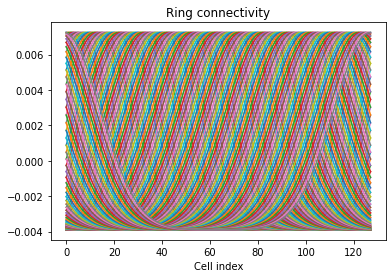

In [6]:
my_ring2 = IntegratorLayer(**PARAMS_Integrator)
plt.plot(my_ring2.weights[:,:])
plt.title('Ring connectivity')
plt.xlabel('Cell index')

Let us now look at the dynamics of the bump when the network is stimulated by an external guassian stimulus.

In [7]:
def my_dynamics(PARAMS_Integrator,t_total,dt,waiting_time,resting_time,external_stimulus=0.0, **kwargs):
    '''
    this function omputes the dynamics of a ring network during a time t_total, with a time_step dt, and apply the external stimulus after a small waiting time
    '''
    my_ring = IntegratorLayer(**PARAMS_Integrator)
    
    for t in np.arange(0,waiting_time,dt):
        my_ring.dr_dt(dt,0.0*external_stimulus)

    rate_waiting = my_ring.get_rate()
    for t in np.arange(0,t_total,dt):
        
        my_ring.dr_dt(dt,external_stimulus)
        #print(my_ring.get_rate())
        
    rate_total = my_ring.get_rate()
    
    for t in np.arange(0,resting_time,dt):
        my_ring.dr_dt(dt,0.0*external_stimulus)
    rate_resting = my_ring.get_rate()
    
    return np.array([rate_waiting,rate_total,rate_resting])



def create_stimulus(value,angular_target, Ncells,sigma_con, **kwargs):
    '''
    this function creates a stimulus with a given angular target
    '''
    theta_range = np.linspace(0.0, 360.0 - 360.0/Ncells,Ncells)
    min_dir = np.abs(theta_range - angular_target)
    min_dir[min_dir>180.0] = min_dir[min_dir>180.0] - 360.0
    stim = np.exp(-0.5*(min_dir)**2/sigma_con**2)
    return value*stim

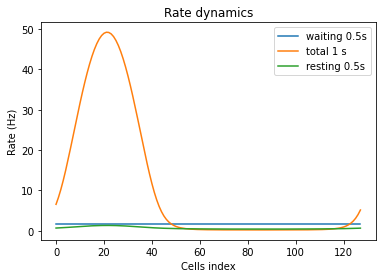

In [15]:
PARAMS_Simulation = {
    'waiting_time': 0.5,
    't_total': 1.0,
    'dt': 0.0005,
    'resting_time': 2.0}

stim = create_stimulus(0.2,60.0,**PARAMS_Integrator)

my_rate = my_dynamics(PARAMS_Integrator,**PARAMS_Simulation,external_stimulus=stim)

plt.plot(my_rate.transpose(), label = ['waiting 0.5s','total 1 s','resting 0.5s'])
plt.title('Rate dynamics')
plt.xlabel('Cells index')
plt.ylabel('Rate (Hz)')
plt.legend()

Let's know do a study of the relaxation time constant as a function of the input and/or the $\alpha$ in the equations.

In [28]:
def get_relaxation_dynamics(PARAMS_Integrator, t_total, dt, resting_time, external_stimulus = 0.0,**kwargs):
    ''' This function computes the relaxation dynamics of the network, taking a simulation dict into parameters and saving the maximal firing rate of the bump at each time step. 
    '''
    my_ring = IntegratorLayer(**PARAMS_Integrator)
    for t in np.arange(0,t_total,dt):
        my_ring.dr_dt(dt,external_stimulus)

    saved_max_rate = np.zeros(int(resting_time/dt))
    for count,t in enumerate(np.arange(0,resting_time,dt)):
        my_ring.dr_dt(dt,0.0*external_stimulus)
        saved_max_rate[count] = np.max(my_ring.get_rate())
    # plt.plot(saved_max_rate)
    # plt.title('Relaxation time')
    # plt.xlabel('Time (s)')
    # plt.ylabel('Rate (Hz)')
    # plt.show()
    return np.arange(0,resting_time,dt), saved_max_rate

In [29]:
time_range,saved_max_rate = get_relaxation_dynamics(PARAMS_Integrator,**PARAMS_Simulation, external_stimulus=stim)

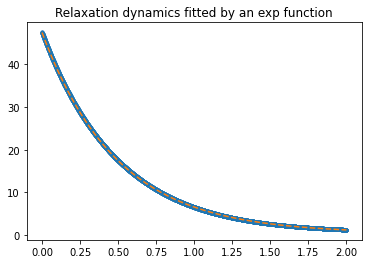

In [37]:
def monoExp(x, m, t, b):
    return m * np.exp(-t * x) + b

p0 = (100, .1, 0) # start with values near those we expect
params, cv = scipy.optimize.curve_fit(monoExp, time_range, saved_max_rate , p0)
m, t, b = params

plt.plot(time_range, saved_max_rate, '.', label="data")
plt.plot(time_range, monoExp(time_range, m, t, b), '--', label="fitted")
plt.title('Relaxation dynamics fitted by an exp function')


def get_relaxation_time(PARAMS_Integrator, PARAMS_Simulation, external_stimulus = stim):
    ''' Get the time constant of the relaxation dynamics after fit by exponential
    '''
    time_range,saved_max_rate = get_relaxation_dynamics(PARAMS_Integrator,**PARAMS_Simulation, external_stimulus=stim)
    p0 = (100, .5, 0) # start with values near those we expect
    params, cv = scipy.optimize.curve_fit(monoExp, time_range, saved_max_rate , p0)
    m, t, b = params
    return 1.0/t

In [38]:
get_relaxation_time(PARAMS_Integrator,PARAMS_Simulation, external_stimulus=stim)

0.24843527420512923

Text(0, 0.5, 'relaxation time constant (s)')

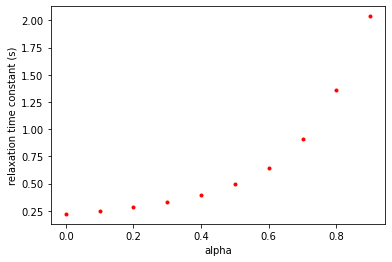

In [44]:
alpha_list = np.linspace(0.0,0.9,10)
relaxation_list = np.zeros(len(alpha_list))

for count,alpha in enumerate(alpha_list):
    PARAMS_Integrator['alpha'] = alpha
    # print(alpha)
    relaxation_list[count] = get_relaxation_time(PARAMS_Integrator,PARAMS_Simulation, external_stimulus=stim)
    
plt.plot(alpha_list,relaxation_list,'.' ,label='relaxation time constant',color='red')
plt.xlabel('alpha')
plt.ylabel('relaxation time constant (s)')

So as expected, for low $\alpha$, the time constant of the relaxation is the direct time constant of the integrator $0.2$ seconds. However, as $\alpha$ increases, this effective time constant increases too.